## Bluebike Forecasting

Time series forecasting can broadly be categorized into the following categories:
- Classical / Statistical Models — Auto Regression, Moving Averages, Exponential smoothing, ARIMA, SARIMA, TBATS
- Machine Learning — XGBoost, Random Forest, or any ML model with reduction methods
- Deep Learning — RNN, LSTM<br>
Here we will explore **ARIMA**

**ARIMA Model for Time Series Forecasting**

ARIMA stands for autoregressive integrated moving average model and is specified by three order parameters: (p, d, q).

**AR(p) Autoregression** – a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.

**I(d) Integration** – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.

**MA(q) Moving Average** – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.
Types of ARIMA Model
- ARIMA  :Non-seasonal Autoregressive Integrated Moving Averages
- SARIMA :Seasonal ARIMA
- SARIMAX:Seasonal ARIMA with exogenous variables
- Pyramid Auto-ARIMA

The ‘auto_arima’ function from the ‘pmdarima’ library helps us to identify the most optimal parameters for an ARIMA model and returns a fitted ARIMA model.


reference : https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

In [ ]:
# Loading the data (All trip data)
trip_data = pd.read_pickle("/content/drive/MyDrive/blue_bikes_sales_prediction/data/raw_data.pkl")

In [ ]:
trip_data.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,350,2017-01-01 00:06:58,2017-01-01 00:12:49,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,139,Dana Park,42.36178,-71.1081,644,Subscriber,NaN


In [ ]:
# preprocessing
def get_groupby(data,condition):
  '''
  Etract day, month, hour from timestamp
  grouping by condition = 'hour' or 'date','year'

  '''
  df = data.copy()
  
  # extracting the yesr,date,hour from time stamp
  df['year'] = df.starttime.dt.year
  df['month'] = df.starttime.dt.month
  df['date'] = df.starttime.dt.date
  df['hour'] = df.starttime.dt.hour

  if condition == 'year':
    df = df.groupby(['year']).size().reset_index(name = 'Totalrides')
  if condition == 'month':
    df = df.groupby(['year','month']).size().reset_index(name = 'Totalrides')
  if condition == 'date':
    df = df.groupby(['year','month','date']).size().reset_index(name = 'Totalrides')
    df['date'] = pd.to_datetime(df.date)
  if condition == 'hour':
    df = df.groupby(['year','month','date','hour']).size().reset_index(name = 'Totalrides')    
  return df

In [ ]:
df = get_groupby(trip_data,'date')
df.head(3)

,year,month,date,Totalrides
0,2017,1,2017-01-01,481
1,2017,1,2017-01-02,802
2,2017,1,2017-01-03,651


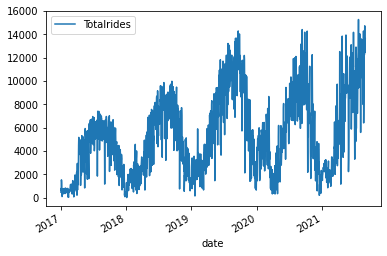

In [ ]:
df = df[['date','Totalrides']]

df.plot(x = 'date')
plt.show()


In [ ]:
#df.set_index('date',inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702 entries, 0 to 1701
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1702 non-null   datetime64[ns]
 1   Totalrides  1702 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 26.7 KB


Since ARIMA model works on stationary series, we check statistically whether the series is stationary, even though the above plot shows stong seasonality pattern

In [ ]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Totalrides'])
def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is STATIONARY")
else:
    print("Weak evidence against null hypothesis,indicating it is NON-STATIONARY ")

adfuller_test(df.Totalrides)

Weak evidence against null hypothesis,indicating it is NON-STATIONARY 
ADF Test Statistic : -2.129929927771611
p-value : 0.2326511425724177
#Lags Used : 25
Number of Observations : 1676


## Methods to make a series stationary:
1. Differencing
2. Log
3. nth squareroot
4. Combining

In [ ]:
# Differencing
df['Rides First Difference'] = df['Totalrides'] - df['Totalrides'].shift(1)
df['Seasonal First Difference']=df['Totalrides']-df['Totalrides'].shift(12)
df['Seasonal Second Difference']=df['Totalrides']-df['Totalrides'].shift(30)
df.head()

,date,Totalrides,Rides First Difference,Seasonal First Difference,Seasonal Second Difference
0,2017-01-01,481,NaN,NaN,NaN
1,2017-01-02,802,321.0,NaN,NaN
2,2017-01-03,651,-151.0,NaN,NaN
3,2017-01-04,1534,883.0,NaN,NaN
4,2017-01-05,1330,-204.0,NaN,NaN


In [ ]:
# Again testing if data is stationary
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -6.890103058577875
p-value : 1.3625716536188053e-09
#Lags Used : 25
Number of Observations : 1664


We see that $p <0.05$ which means we will be rejecting the null hypothesis. So data is STATOINARY.














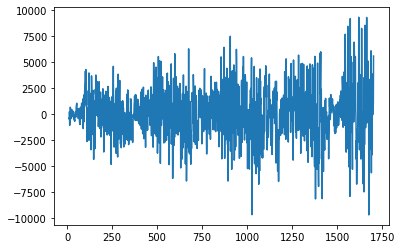

In [ ]:
df['Seasonal First Difference'].plot()

ADF Test Statistic : -4.503492160438024
p-value : 0.00019380251180633345
#Lags Used : 24
Number of Observations : 1647


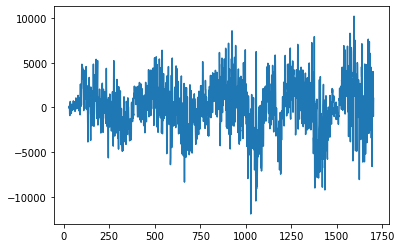

In [ ]:
adfuller_test(df['Seasonal Second Difference'].dropna())
df['Seasonal Second Difference'].plot()

We see that this is also STATIONARY.

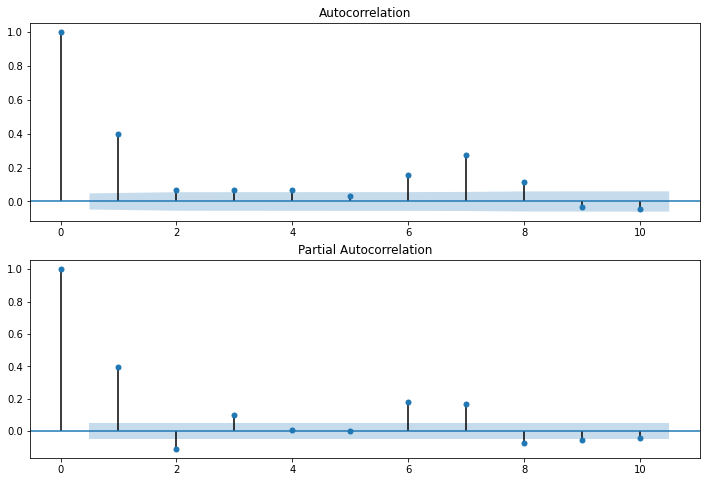

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=10,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=10,ax=ax2)

In [ ]:
# For non-seasonal data

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['Totalrides'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Totalrides   No. Observations:                 1701
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14870.592
Method:                       css-mle   S.D. of innovations           1514.842
Date:                Mon, 01 Nov 2021   AIC                          29749.184
Time:                        20:57:33   BIC                          29770.940
Sample:                             1   HQIC                         29757.238
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.8987      6.979      0.988      0.323      -6.780      20.577
ar.L1.D.Totalrides     0.3102      0.028     11.266      0.000       0.256       0.364
ma.L1.D.Totalrides    -0.8694      0.012    -71.309      0.000      -0.893      -0.846
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.2241           +0.0000j            3.2241            0.0000
MA.1            1.1502           +0.0000j            1.1502            0.0000
-----------------------------------------------------------------------------
"""

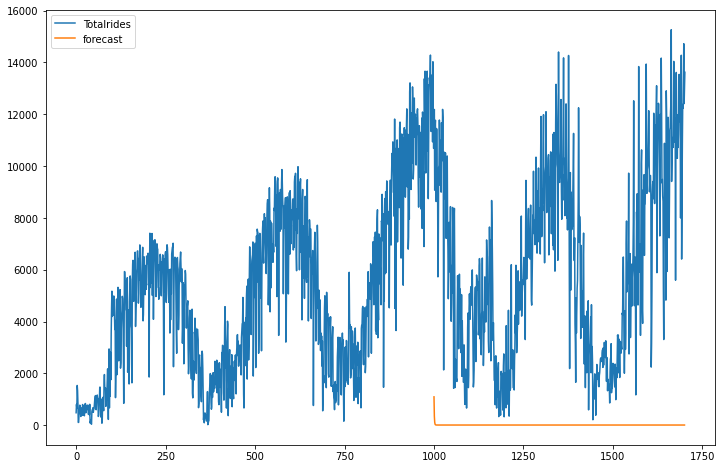

In [ ]:
df['forecast']=model_fit.predict(start=1000,end=1700,dynamic=True)
df[['Totalrides','forecast']].plot(figsize=(12,8))

We see that the predictions are not useful.

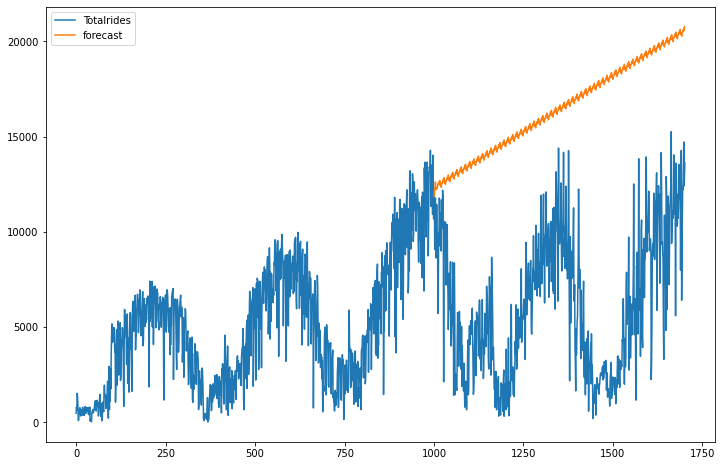

In [ ]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Totalrides'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=1000,end=1700,dynamic=True)
df[['Totalrides','forecast']].plot(figsize=(12,8))